In [2]:
import torch

torch.cuda.is_available()

True

# Model Selection

We want real-time inference and have very little data to work with, so we will select a pre-trained MobileNet_V2 as a model for image classification. 

In [3]:
import torchvision

mobilenet_v2 = torchvision.models.mobilenet_v2(pretrained=True, progress=True)

## EDA

The dataset description:
- 1646 training images 
- 706 test images.

The task will be binary image classification. The labels are:
- 0 = non-emergency vehicle
- 1 = emergency vehicle

The classes are mildly unbalanced:
- 59% non-emergency vehicles
- 41% emergency vehicles

Since this is a Kaggle dataset, the test images did not come with labels, so there is not validation split. The test set is an external validation set to be submitted to Kaggle.

I will make a stratified validation split by randomly selecting 10% of the training images for the validation split.
The slight imbalance of the training set will be maintained at 60:40 non-emergency:emergency.
- non-emergency vehicles: 98
- emergency vehicles: 66
- total validation set size : 164



In [3]:
import pandas as pd


data_dir = '/home/ubuntu/datasets/Emergency_Vehicles/'

train_labels = pd.read_csv(data_dir + 'train.csv')
test_labels = pd.read_csv(data_dir + 'test.csv')

train_labels.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [4]:
train_labels['emergency_or_not'].value_counts()

0    965
1    681
Name: emergency_or_not, dtype: int64

In [5]:
total = 965 + 681
print('Not Emergency: ', round(965 / total, 2), '\nEmergency: ', round(681 / total, 2))

Not Emergency:  0.59 
Emergency:  0.41


In [6]:
test_labels.head()

,image_names
0,1960.jpg
1,668.jpg
2,2082.jpg
3,808.jpg
4,1907.jpg


In [7]:
non_em = round(164 * .6, 0)
em = round(164 *.4, 0)
print('validation set univariate statistics', 
'\nnon-emergency vehicles: ', non_em,
'\nemergency vehicles: ', em,
'\nvalidation set size: ', non_em + em)

validation set univariate statistics 
non-emergency vehicles:  98.0 
emergency vehicles:  66.0 
validation set size:  164.0


## Dataset Class

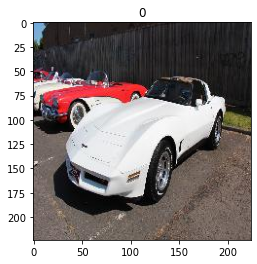

In [4]:
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
# optional image reader
# from torchvision.io import read_image
from PIL import Image
import pandas as pd
import glob
import os
import numpy as np



class Emergency_Vehicles(Dataset):
    def __init__(self, data_dir, split, batch_size = 32,transform=None, 
    target_transform=None):
        self.data_dir = data_dir
        self.train_labels = pd.read_csv(data_dir + 'train.csv')
        self.val_labels = pd.read_csv(data_dir + 'val.csv')
        self.train_imgs = glob.glob(data_dir + 'train/' + '*.jpg')
        self.test_imgs = glob.glob(data_dir + 'test/' + '*.jpg')
        self.val_imgs = glob.glob(data_dir + 'val/' + '*.jpg')
        self.transform = transform
        self.target_transform = target_transform
        self.split = split

    def __len__(self):
        ''' test images are not labeled'''
        return {'train': len(self.train_imgs), 'test': len(self.test_imgs)}

    def __getitem__(self, idx):
        if self.split == 'train':
            img_path = os.path.join(self.data_dir, self.split, self.train_labels.iloc[idx, 0])
            label = self.train_labels.iloc[idx, 1]
        else:
            img_path = os.path.join(self.data_dir, self.split, self.val_labels.iloc[idx, 1])
            label = self.val_labels.iloc[idx, 2]
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

dataset = Emergency_Vehicles(data_dir, 'train')
idx = 42
img, label = dataset[idx]
# if using read_image, transform to channels last for plotting
# img = np.array(img)
# img = np.moveaxis(img, 0, -1)

plt.imshow(img)
plt.title(label)
plt.show()

## Splitting The Data

As of 7-28-22, the best course of action to take advantage of pytorch dataloading functions is to re-structure the dataset so that the directory names contain the labels (emergency, non-emergency). Most Pytorch helper functions assume datasets are organized this way.

I will use the csv files that I created when I split the data to copy the images rather than move them, creating a new version of the dataset just in case something goes wrong. Version 2 of the dataset will be stored in a directory called dataset_v2.

### Old split_data function

I will modify the split_data function to create a new restructure function that will copy the images to the new directories.

In [8]:

def split_data(data_labels, split_ratio, stratification=[.6, .4]):
    ''' takes the labels file and outputs two dataframes representing the 
        validation set. 
    '''
    np.random.seed(42)
    train = data_labels
    size = len(data_labels)
    sample_sizes = [int(size * split_ratio * s) for s in stratification]

    # get indices of non-emergency and emergency labels
    non_emergency = data_labels[data_labels['emergency_or_not'] == 0 ].index
    emergency = data_labels[data_labels['emergency_or_not'] == 1 ].index
    print('non-emergency: ', len(non_emergency), '\nemergency: ', len(emergency))
    output = []
    for idx in range(2):
        if idx == 0:
            # randomly sample ~60% of indices
            idxs = np.random.choice(non_emergency, sample_sizes[idx])
            # store rows
            output.append(data_labels.iloc[idxs])
            # remove rows from training set
            train = train.drop(idxs, axis=0)
        else:
            # randomly sample ~ 40% of indices
            idxs = np.random.choice(emergency, sample_sizes[idx])
            output.append(data_labels.iloc[idxs])
            # remove indices
            train = train.drop(idxs, axis=0)
    val = pd.concat(output, axis=0)
    # sometimes there are duplicates
    val = val.drop_duplicates()
    return train, val



dfs = split_data(dataset.train_labels, .10)
for df in dfs:
    print(len(df))
    print(df.head())

non-emergency:  965 
emergency:  681
1495
  image_names  emergency_or_not
0    1503.jpg                 0
2    1764.jpg                 0
3    1356.jpg                 0
4    1117.jpg                 0
5      45.jpg                 1
151
     image_names  emergency_or_not
163     1159.jpg                 0
746     1942.jpg                 0
1484    1661.jpg                 0
449     1920.jpg                 0
173     2016.jpg                 0


## Restructure function

The restructure function was successful with most images, which doesn't  appear to be in the training folder. This image was already found in the val directory and was copied into the val folder in the new restructured dataset.

In [9]:
import pandas as pd


data_dir = '/home/ubuntu/datasets/Emergency_Vehicles/'

train_labels = pd.read_csv(data_dir + 'train.csv')
val_labels = pd.read_csv(data_dir + 'val.csv')

val_labels.head()

,Unnamed: 0,image_names,emergency_or_not
0,163,1159.jpg,0
1,746,1942.jpg,0
2,1484,1661.jpg,0
3,449,1920.jpg,0
4,173,2016.jpg,0


In [25]:
import shutil

def restructure(labels_files:dict()):
    ''' takes the pandas labels dataframes, creates a new directory structure
        and copies images to the new directories using their labels. 
    '''
    data_dir = '/home/ubuntu/datasets/Emergency_Vehicles/dataset_v2/'
    
    print('reading labels files...')
    for split in ['train', 'val']:
        data_labels = labels_files[split]
        # get indices of non-emergency and emergency labels
        non_emergency = data_labels[data_labels['emergency_or_not'] == 0 ].index
        emergency = data_labels[data_labels['emergency_or_not'] == 1 ].index
        idx_holder = {'emergency': emergency, 'non-emergency':non_emergency}
        print(split)
        print('non-emergency: ', len(non_emergency), '\nemergency: ', len(emergency))
        for lab in ['emergency', 'non-emergency']:

            # select vehicles based on their label
            filtered = data_labels.iloc[idx_holder[lab]]
            print(f'Copying {len(filtered)} {lab} images...')
            origin = '/home/ubuntu/datasets/Emergency_Vehicles/' + split
            print(data_dir + split + '/' + lab)
            os.makedirs(data_dir + split + '/' + lab, exist_ok=True)
            for img in filtered['image_names']: # len(emergency)):
                        
                img_path = origin + '/' + img
                
                destination = data_dir + split + '/' + lab + '/' + img
                
                try:
                    shutil.copy(img_path, destination)
                except FileNotFoundError as e:
                    print(e) 
                    print(img_path, '\n', destination)
                    print()

labs = {'train':train_labels, 'val':val_labels}

restructure(labs)

reading labels files...
train
non-emergency:  965 
emergency:  681
Copying 681 emergency images...
/home/ubuntu/datasets/Emergency_Vehicles/dataset_v2/train/emergency
[Errno 2] No such file or directory: '/home/ubuntu/datasets/Emergency_Vehicles/train/436.jpg'
/home/ubuntu/datasets/Emergency_Vehicles/train/436.jpg 
 /home/ubuntu/datasets/Emergency_Vehicles/dataset_v2/train/emergency/436.jpg

[Errno 2] No such file or directory: '/home/ubuntu/datasets/Emergency_Vehicles/train/352.jpg'
/home/ubuntu/datasets/Emergency_Vehicles/train/352.jpg 
 /home/ubuntu/datasets/Emergency_Vehicles/dataset_v2/train/emergency/352.jpg

[Errno 2] No such file or directory: '/home/ubuntu/datasets/Emergency_Vehicles/train/37.jpg'
/home/ubuntu/datasets/Emergency_Vehicles/train/37.jpg 
 /home/ubuntu/datasets/Emergency_Vehicles/dataset_v2/train/emergency/37.jpg

[Errno 2] No such file or directory: '/home/ubuntu/datasets/Emergency_Vehicles/train/331.jpg'
/home/ubuntu/datasets/Emergency_Vehicles/train/331.jpg 
 /

## Move the Validation images out of the dataset

There may be duplicate values in the val dataset? Each image the code below states is not found is actually in the val directory

In [9]:
# check for duplicates in validation set
print(len(dfs[1]))
print(len(dfs[1].drop_duplicates()))

151
151


In [12]:
names = ['train_2.csv', 'val.csv']
os.makedirs(data_dir + 'val/', exist_ok=True)

for idx, df in enumerate(dfs):
    df.to_csv(data_dir + names[idx])
    if idx == 1:
        for img in df['image_names']:
            origin = data_dir + 'train/' + img
            
            destination = data_dir + 'val/' + img
            try:
                os.rename(origin, destination)
            except FileNotFoundError as e:
                print(e) 
                continue

In [13]:
print(len(dfs[1]))
print(len(os.listdir(data_dir + 'val')))
print(len(np.unique(dfs[1]['image_names'])))

151
151
151


## Image preprocessing

Since the objective is image classification using a model that was pre-trained on ImageNet, we will use the following transformations:
- resize each image to (256, 256)
- Normalize to ImageNet mean and std
- Centering and Cropping the image
- 50% horizontal flip


In [4]:
from torchvision import transforms as T
from torchvision import datasets

def data_transformers(split:str):
    # using ImageNet mean and standard deviations to normalize images
    mu = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # training images will be randomly cropped and horizontally flipped
    # validation images will only be normalized
    data_transforms = {'train': T.Compose([
        T.RandomResizedCrop(224),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mu, std)
        ]),
        'val': T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mu, std)
        ])}
    return data_transforms[split]

train_trans = data_transformers('train')
val_trans = data_transformers('val')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


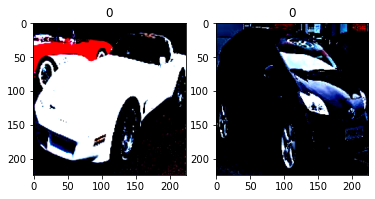

In [6]:
train = Emergency_Vehicles(data_dir, 'train', transform=train_trans)
val = Emergency_Vehicles(data_dir, 'val', transform=val_trans)
idx = 42
train_ex= train[idx]
val_ex = val[idx]

examples = [train_ex, val_ex]


img = np.array(examples[0][0])
img = np.moveaxis(img, 0, -1)
plt.subplot(1,2,1)
plt.imshow(img)
plt.title(examples[0][1])
img = np.array(examples[1][0])
img = np.moveaxis(img, 0, -1)
plt.subplot(1,2,2)
plt.imshow(img)
plt.title(examples[1][1])
plt.show()

## Dataset V2

Now that the dataset is restructured, we can make use of native pytorch helper functions.

In [5]:
data_dir = '/home/ubuntu/datasets/Emergency_Vehicles/dataset_v2/'
batch_size = 16
tset = datasets.ImageFolder(os.path.join(data_dir, 'train'), train_trans)
vset = datasets.ImageFolder(os.path.join(data_dir, 'val'), val_trans)
dsets = {'train': tset, 'val': vset}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=batch_size,
                                               shuffle=True, num_workers=25)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes

for k,v in dset_sizes.items():
    print(k, v)
print(dset_classes)
print('number of batches in each data loader')
for k,v in dset_loaders.items():
    print(k,len(v))

train 1495
val 151
['emergency', 'non-emergency']
number of batches in each data loader
train 94
val 10


In [43]:
from time import time
import copy


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def train_model(model, dataloaders:dict(), criterion, optimizer, lr_scheduler, num_epochs=2):
    since = time()
    val_acc_history = []

    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                # optimizer = lr_scheduler(optimizer, epoch)
                model.train().to(device)
            else:
                model.eval().to(device)

            running_loss = 0.0
            running_corrects = 0

            for imgs, labels in dataloaders[phase]:
                imgs = imgs.to(device)

                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase  == 'train'):
                    outputs = model(imgs)
                    loss = criterion(outputs.double(), labels.unsqueeze(1).double())
                    preds = torch.clip(outputs, 0, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
    
                running_loss += loss.item() * imgs.size(0)
                running_corrects += torch.sum(preds == labels)
            scheduler.step()
            print(f'running loss: {running_loss} \n running corrects: {running_corrects}')
            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects / (len(dataloaders[phase]) * imgs.size(0))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            # return {'imgs': imgs, 'labels':labels, 'outputs':outputs,'preds':preds, 'running_corrects': running_corrects}
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        print()
    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model)
    return model, val_acc_history

device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.Adam(mobilenet_v2.parameters(), .0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = .9)
criterion = torch.nn.BCEWithLogitsLoss()
mobilenet_v2.classifier = torch.nn.Linear(1280, 1)
outputs = train_model(mobilenet_v2, dset_loaders, criterion, optimizer, scheduler, num_epochs=2)

Epoch 0/1
----------
running loss: 502.806312540899 
 running corrects: 9288
train Loss: 5.3490 Acc: 14.1155
running loss: 30.392587076773747 
 running corrects: 1218
val Loss: 3.0393 Acc: 17.4000

Epoch 1/1
----------
running loss: 353.7436012761856 
 running corrects: 11609
train Loss: 3.7632 Acc: 17.6429
running loss: 25.31043852281498 
 running corrects: 1248
val Loss: 2.5310 Acc: 17.8286

Training complete in 0m 14s
Best val Acc: 17.828571


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


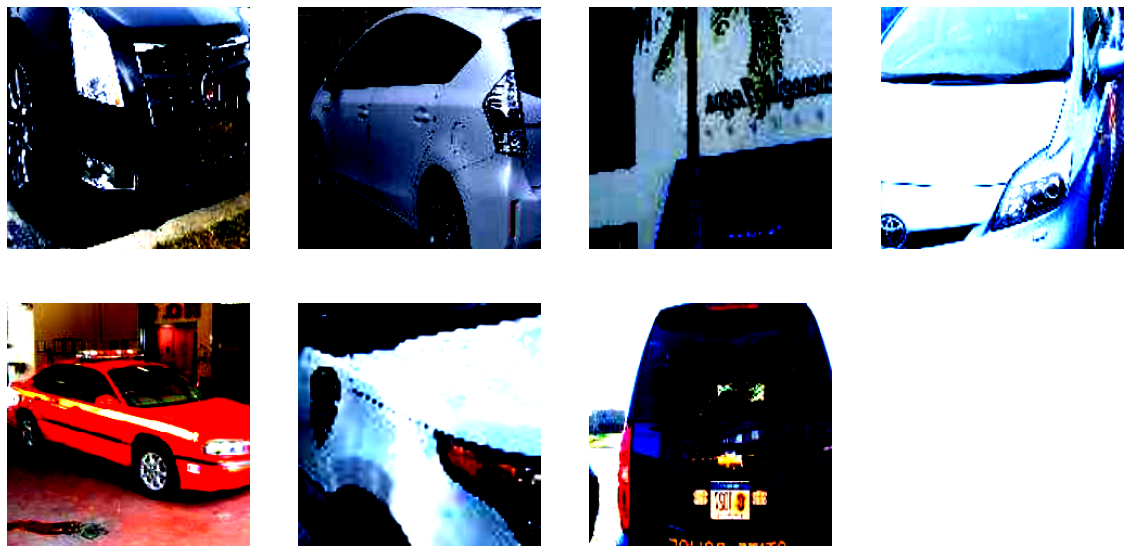

In [36]:
import matplotlib.pyplot as plt
import numpy as np

imgs = outputs['imgs'].cpu()
plt.figure(figsize=(20,10))
for idx, im in enumerate(imgs[:8,...]):
    im = np.array(im)
    im = np.moveaxis(im, 0, -1)
    plt.subplot(2,4,idx + 1)
    plt.imshow(im)
    plt.axis('off')


In [47]:
for k,v in outputs.items():
    if k != 'imgs':
        print(k,v)

labels tensor([0, 0, 0, 1, 0, 0, 1], device='cuda:0')
outputs tensor([[ 3.6330],
        [-3.1433],
        [-1.4560],
        [ 6.2666],
        [-1.1111],
        [-5.1815],
        [ 4.8592]], device='cuda:0', grad_fn=<AddmmBackward0>)
preds tensor([0, 0, 0, 0, 0, 0, 0], device='cuda:0')
running_corrects tensor(622, device='cuda:0')


In [58]:
outputs[1]

[tensor(0.8429, device='cuda:0', dtype=torch.float64),
 tensor(0.8429, device='cuda:0', dtype=torch.float64),
 tensor(0.8429, device='cuda:0', dtype=torch.float64),
 tensor(0.8429, device='cuda:0', dtype=torch.float64),
 tensor(0.8429, device='cuda:0', dtype=torch.float64),
 tensor(0.8429, device='cuda:0', dtype=torch.float64),
 tensor(0.8429, device='cuda:0', dtype=torch.float64),
 tensor(0.8429, device='cuda:0', dtype=torch.float64),
 tensor(0.8429, device='cuda:0', dtype=torch.float64),
 tensor(0.8429, device='cuda:0', dtype=torch.float64),
 tensor(0.8429, device='cuda:0', dtype=torch.float64),
 tensor(0.8429, device='cuda:0', dtype=torch.float64),
 tensor(0.8429, device='cuda:0', dtype=torch.float64),
 tensor(0.8429, device='cuda:0', dtype=torch.float64),
 tensor(0.8429, device='cuda:0', dtype=torch.float64),
 tensor(0.8429, device='cuda:0', dtype=torch.float64)]

In [35]:
data_dir = '/home/ubuntu/datasets/Emergency_Vehicles/dataset_v2/'
batch_size = 4
tset = datasets.ImageFolder(os.path.join(data_dir, 'train'), train_trans)
vset = datasets.ImageFolder(os.path.join(data_dir, 'val'), val_trans)
dsets = {'train': tset, 'val': vset}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=batch_size,
                                               shuffle=True, num_workers=25)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes

for k,v in dset_sizes.items():
    print(k, v)
print(dset_classes)
print('number of batches in each data loader')
for k,v in dset_loaders.items():
    print(k,len(v))

train 1495
val 151
['emergency', 'non-emergency']
number of batches in each data loader
train 374
val 38


In [26]:
imgs, labels = next(iter(dset_loaders['val']))

print(imgs.size(), labels.size())

torch.Size([16, 3, 224, 224]) torch.Size([16])


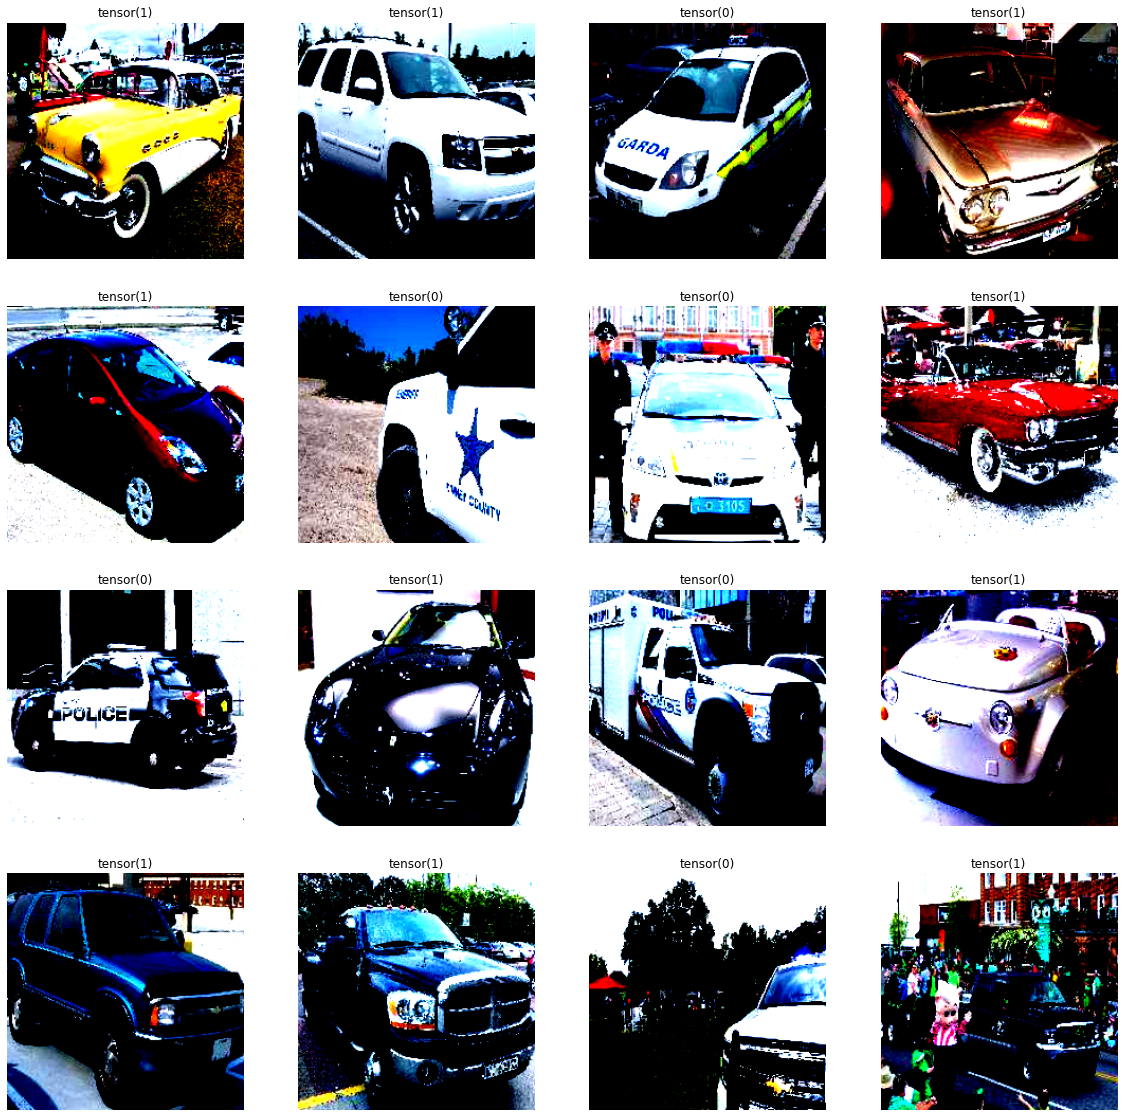

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,20))
for idx, (im, lab) in enumerate(zip(imgs, labels)):
    im = np.array(im)
    im = np.clip(im, 0, 1)
    im = np.moveaxis(im, 0, -1)
    plt.subplot(4,4,idx + 1)
    plt.imshow(im)
    plt.title(lab)
    plt.axis('off')


In [17]:
outputs[0].eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [45]:
logits = outputs[0](imgs.to(device))
print(logits, logits.size())

tensor([[ 2.7712],
        [ 4.1587],
        [-6.0926],
        [ 2.4469],
        [ 4.1796],
        [-1.1222],
        [-2.5405],
        [ 3.3598],
        [-3.7999],
        [ 4.2406],
        [-3.9317],
        [ 3.8088],
        [ 3.4456],
        [ 2.7647],
        [ 2.2264],
        [-0.9057]], device='cuda:0', grad_fn=<AddmmBackward0>) torch.Size([16, 1])


In [35]:
_, preds = torch.max(logits, 1)
preds

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [55]:
preds = torch.clip(logits, 0, 1)
correct = torch.sum(preds == labels.data.to(device), dim=0)
print(correct)

tensor([10, 10,  6, 10, 10,  6,  6, 10,  6, 10,  6, 10, 10, 10,  6, 10],
       device='cuda:0')


In [49]:
(preds == labels.to(device), dim=1)

SyntaxError: invalid syntax (3628418366.py, line 1)